### Distribution function for the DM mini-halo

The idea is the construct an equilibrium distribution function for a DM mini-halo (around a PBH) with a density profile $\rho \sim r^{-3/2}$ within the truncation radius $r_\mathrm{tr}$. 

In [5]:
import numpy as np
import sympy as sp

from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad
from scipy.special import betainc, beta, btdtr,hyp2f1

from sympy.assumptions import assuming, Q

from __future__ import division

from matplotlib import pylab as pl
import matplotlib as mpl
mpl.rc('font', **{'size':16})

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1

def beta_incomplete(a,b,x):
    return (x**a/a)*hyp2f1(a,1-b,a+1,x)

**Parameters:**

In [6]:
MPBH = 30.0
rtr = 0.0063*(MPBH**(1.0/3.0))
G = 4.302e-3 #Units of (pc/solar mass) (km/s)^2
A = 3.0*MPBH/(8*np.pi*rtr**3)
B = G*MPBH/rtr


**DM Density profile:**

In [7]:
x_a = 1.0

rho0 = 1.0
#rho0 = MPBH*(105/16)/((4*np.pi*rtr**3))

def rho_inner(x):
    return 1.0/((x**(3/2))*(1 + x)**(6-3/2))    

alpha = 1.0*rho_inner(x_a)
#beta = (1.0/alpha)*1.0*3*(1+4*x_a)/(2*x_a**(5/2)*(1+x_a)**(11/2))
beta = 3*(1+4*x_a)/(2.0*x_a*(1+x_a))

def rho_outer(x):
    return alpha*sp.exp(-1.0*beta*(x-x_a))

def rho(x):
    if (x < x_a):
        return rho_inner(x)
    if (x >= x_a):
        return rho_outer(x)

def P(x):
    return 4*np.pi*1.0*x**(1/2)/((1 + x)**(6-3/2))

def rho_true(x):
    if (x > 1.0):
        return 1.0
    return A*x**(-1.5)

rho_vec = np.vectorize(rho)


**Plot the density...**

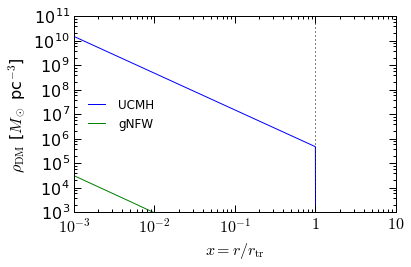

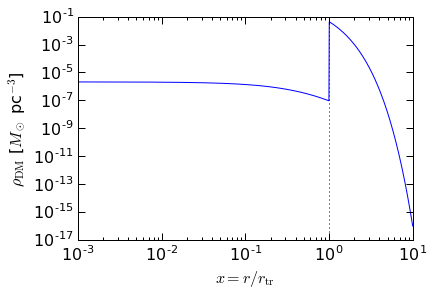

In [8]:
#Check the density
pl.figure()
xlist = np.logspace(np.log10(1e-3), np.log10(10),1000)
pl.loglog(xlist, np.vectorize(rho_true)(xlist), label='UCMH')
pl.loglog(xlist, rho0*np.vectorize(rho)(xlist),label='gNFW')
#pl.loglog(xlist, rho_inner(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")
pl.ylim(1e3, 1e11)
#pl.xlim(0.5, 5)
pl.axvline(1.0, linestyle=':', color='k')
#pl.axvline(x_b, linestyle=':', color='k')
pl.legend(loc="best",fontsize=12.0,frameon=False)
pl.xticks([1e-3, 1e-2, 1e-1, 1, 10], [r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$1$',r'$10$'])

pl.tight_layout()
pl.savefig("../../Halo_density.pdf",bbox_inches="tight" )
pl.show()

#Check the density
pl.figure()
xlist = np.logspace(np.log10(1e-3), np.log10(10),1000)
pl.loglog(xlist, np.vectorize(rho)(xlist)/np.vectorize(rho_true)(xlist),label='gNFW')
#pl.loglog(xlist, rho_inner(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")
#pl.ylim(0, 1e6)
#pl.xlim(0.5, 5)
pl.axvline(1.0, linestyle=':', color='k')
#pl.axvline(x_b, linestyle=':', color='k')
#pl.legend(loc="best",fontsize=10.0)
#pl.tight_layout()
#pl.savefig("../../Halo_density.pdf",bbox_inches="tight" )
pl.show()

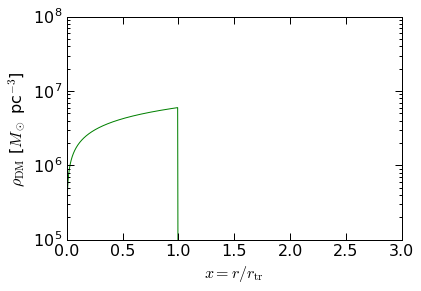

In [9]:
#Check the density
pl.figure()
xlist = np.logspace(np.log10(1e-3), np.log10(3),1000)
pl.semilogy(xlist, 4*np.pi*np.vectorize(rho)(xlist)*xlist**2)
pl.semilogy(xlist, 4*np.pi*np.vectorize(rho_true)(xlist)*xlist**2)
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")
pl.ylim(1e5, 1e8)
pl.show()

**Calculate masses and potentials:**

In [10]:
x1,x2,x3,y = sp.symbols('x1 x2 x3 y')
rho0 = 1.0

def Menc_inner(x):
    return rtr**3*4*np.pi*1.0*2*(x**(3/2))*(35 + 28*x + 8*x**2)/(105.0*(1+x)**(7/2))

Mouter_fun = Menc_inner(x_a) + rtr**3*4*np.pi*sp.integrate(rho_outer(x1)*x1**2, (x1, x_a, x2))
print Menc_inner(0.5)
print Mouter_fun.subs(x1,1.5)
rho0 = 30.0/Mouter_fun.subs(x2, 100)
print rho0

def Menc(x):
    if (x < x_a):
        return MPBH + rho0*Menc_inner(x)
    elif (x >= x_a):
        return MPBH + rho0*Mouter_fun.subs(x2, x)    

def psi_outer(y):
    return (MPBH + rho0*Menc_inner(x_a))*G/(rtr*y) - (2**(-9/2))*4*np.pi*rtr**3*(G/rtr)*rho0*(np.exp((x_a - y)*beta)*alpha*(2 -2*np.exp(y*beta) + y*beta)/(y*beta**3))
    
def psi_inner1(y):
    num = 48-70*np.sqrt(y*(1+y)) - 112*np.sqrt(y**3*(1+y))+ \
            -48*np.sqrt(y**5*(1+y)) + 48*y*(3+y*(3+y))
    return (rtr**3*4*np.pi*rho0)*(G/rtr)*2*num/(105.0*(1+y)**3) + MPBH*G/(rtr*y)



def psi_inner(y):
    return psi_inner1(y) - psi_inner1(x_a) + psi_outer(x_a)

def psi(y):
    if (y < x_a):
        return psi_inner(y)
    elif (y >= x_a):
        return psi_outer(y)
    
psi_tr = float(psi(1.0))
psi_min = float(psi(100))
psi_max = float(psi(1e-5))



7.83247900819e-06
-4.72379264934452e-5*x2**2*exp(-3.75*x2) - 2.51935607965041e-5*x2*exp(-3.75*x2) + 1.31294239012073e-5 - 6.71828287906777e-6*exp(-3.75*x2)
2284944.12441367


**Plot the potential and mass enclosed:**

Potential at x = 100: 0.124002083515
Potential at x = 1: 12.3901277015
Potential at x = 1e-5: 659333.579043
 
Mass enclosed at x = 1: 25.7467497582465
Mass enclosed at x = 1.5: 28.7573378620051
Mass enclosed at x = 2: 29.6890411727688
Mass enclosed at x = 5: 29.9999784062280
Mass enclosed between at x = 5 and x = 8: 2.15930810583131e-5
 
Fraction of particles inside x = 1e-2: 0.00465973704321586


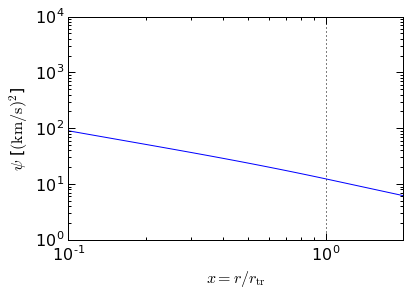

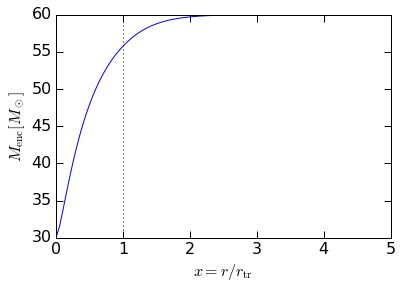

In [12]:
#Check the potential
print "Potential at x = 100:", psi_min
#print "Potential at x = 1.1:", psi_b
print "Potential at x = 1:", psi_tr
print "Potential at x = 1e-5:", psi_max
print " "
print "Mass enclosed at x = 1:", Menc(1.0)-30
print "Mass enclosed at x = 1.5:", Menc(1.5)-30
print "Mass enclosed at x = 2:", Menc(2)-30
print "Mass enclosed at x = 5:", Menc(5)-30
print "Mass enclosed between at x = 5 and x = 8:", Menc(8)-Menc(5)
print " "
print "Fraction of particles inside x = 1e-2:", (Menc(1e-2)-30)/(Menc(100)-30)

pl.figure()
xlist = np.linspace(1e-3, 5, 100)
pl.loglog(xlist, np.vectorize(psi)(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\psi$ [$(\mathrm{km}/\mathrm{s})^2$]")
#pl.axvline(x_a, linestyle=':', color='k')
pl.axvline(1.0, linestyle=':', color='k')
pl.xlim(0.1, 2)
pl.show()

pl.figure()
xlist = np.linspace(0.0, 5, 100)
pl.plot(xlist, np.vectorize(Menc)(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$M_\mathrm{enc} [M_\odot]$")
pl.axvline(1.0, linestyle=':', color='k')
#pl.axvline(x_b, linestyle=':', color='k')
pl.show()

**Calculating density as a function of potential:**

In [44]:
#List of x values
#xlist = np.logspace(-4, np.log10(x_a-0.06),1000)
#xlist = np.append(xlist,np.linspace(x_a-0.05, x_b+0.05),1000)
#xlist = np.append(xlist,np.linspace(x_b+0.06,20,1000))
#xlist = np.sort(xlist)
xlist = np.append(np.logspace(-5, 0, 2000),np.linspace(1.10001, 10.0, 1000))
xlist = np.append(xlist, np.linspace(10.1, 100.0, 1000))
#xlist = np.append(np.logspace(-5, 1, 10000), 1.0)

xlist = np.append(xlist, np.linspace(0.9, 1.1, 1000))
xlist = np.sort(xlist)


In [45]:
rholist = np.vectorize(rho)(xlist)
psilist = np.asarray(np.vectorize(psi)(xlist),dtype='float64')
rholist = np.append(rholist, 0)
psilist = np.append(psilist, 0)
rho_of_psi = UnivariateSpline(psilist[::-1],rholist[::-1],k=5,s=0)

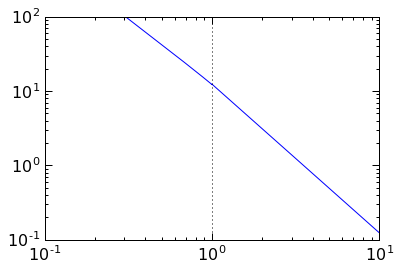

In [46]:

psi_interp = UnivariateSpline(xlist,psilist[:-1],k=5,s=0)
dpsi = psi_interp.derivative(n=1)
pl.figure()
pl.loglog(xlist,-dpsi(xlist))
#pl.semilogy(psilist,alpha1*np.exp(1.1/beta1)*np.exp(-c/(psilist*beta1))*c/(beta1*psilist**2))
#pl.axvline(psi_min, color='k', linestyle=":")
pl.axvline(1.0, color='k', linestyle=":")
pl.xlim(0.1, 10.0)
pl.ylim(1e-1, 1e2)

pl.show()

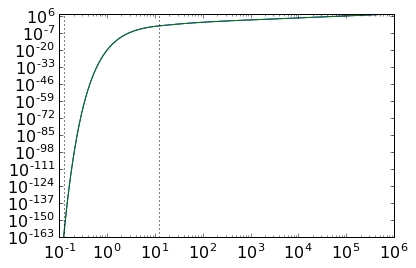

In [928]:
pl.figure()
pl.loglog(psilist,rholist)
pl.loglog(psilist,rho_of_psi(psilist))

pl.axvline(psi_min, color='k', linestyle=":")
pl.axvline(psi_tr, color='k', linestyle=":")
#pl.xlim(psi_tr - 5,psi_tr + 10)
#pl.ylim(1e-20, 1e10)
pl.show()

In [929]:
drho = rho_of_psi.derivative(n=1)
d2rho = rho_of_psi.derivative(n=2)

In [930]:
c = 14.2844298406921
def d2rho_fixed_scalar(p):
    delta = 0.1
    if (p < -1):
        return 0.0
    elif (psi_tr-delta < p <= psi_tr):
        return d2rho(psi_tr - delta)
    elif (psi_tr < p < psi_tr + delta):
        return d2rho(psi_tr + delta)
    elif (p >= -1):
        return d2rho(p)

d2rho_fixed = np.vectorize(d2rho_fixed_scalar)

In [931]:
d2rho(10)

array(0.00222722268938153)

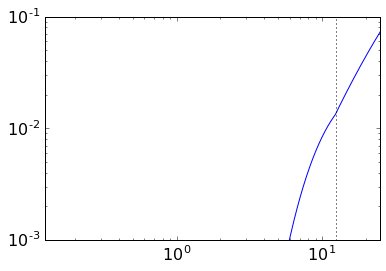

In [932]:
pl.figure()
pl.loglog(psilist,drho(psilist))
#pl.semilogy(psilist,alpha1*np.exp(1.1/beta1)*np.exp(-c/(psilist*beta1))*c/(beta1*psilist**2))
pl.axvline(psi_min, color='k', linestyle=":")
pl.axvline(psi_tr, color='k', linestyle=":")
pl.xlim(psi_min, 2*psi_tr)
pl.ylim(1e-3, 1e-1)
pl.show()

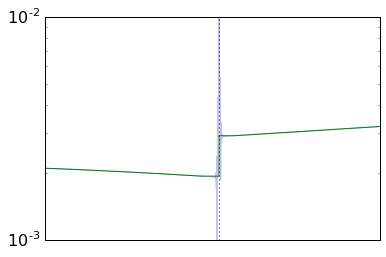

In [933]:
pl.figure()
pl.loglog(psilist,d2rho(psilist), alpha=0.25)
pl.loglog(psilist,d2rho_fixed(psilist))
#pl.plot(psilist,d2rho_fixed(psilist)/np.sqrt(15.0 - psilist))
#pl.plot(psilist,np.vectorize(d2rho_fixed)(psilist))
pl.xlim(psi_tr - 1.0, psi_tr+1.0)
pl.ylim(1e-3, 0.01)
pl.axvline(psi_min, color='k', linestyle=":")
pl.axvline(psi_max, color='k', linestyle=":")
pl.axvline(psi_tr, color='k', linestyle=":")
pl.show()



In [934]:
def calcf1(eps):
    #if (eps <= psi_min):
    #    return 0.0
    if (eps < 1e-10):
        return 0.0
    integ = lambda p: rho0*d2rho_fixed_scalar(p)/np.sqrt(eps - p)
    return quad(integ, 0, eps)[0]/(np.sqrt(8)*np.pi**2)

In [978]:
#e_list = np.append(0.0,np.logspace(np.log10(psi_min), np.log10(psi_max),1000))
e_list = np.append(np.logspace(np.log10(psi_min),np.log10(psi_tr-0.0001), 300),np.logspace(np.log10(psi_tr+0.0001), np.log10(psi_max),300))
#e_list = np.linspace(0.0, 14, 200)
e_list = np.sort(np.append(e_list, np.linspace(psi_tr-1.0, psi_tr+1.0, 100)))
e_list = np.append(0, e_list)
#e_list = np.linspace(0.0, psi_max, 1000)

In [979]:
fvals = 0.0*e_list
for i in tqdm(range(len(e_list))):
    fvals[i] = calcf1(e_list[i])

#print fvals

100%|██████████| 701/701 [02:19<00:00,  3.19it/s]


In [763]:
#e_list, fvals = np.loadtxt("distribution_trunc3.dat", unpack=True)

In [980]:
finterp = UnivariateSpline(e_list, fvals, k=1,s=0)
def f(eps):
    #if (eps < 1):
    #    return 0.0
    return np.clip(finterp(eps),0,1e30)

f_vec = np.vectorize(f)

[ 0.          0.12400208  0.12592639  0.12788056  0.12986505]
[  0.00000000e+00  -2.44141683e-07  -2.22333143e-07  -7.65868362e-08
   8.54264730e-07]


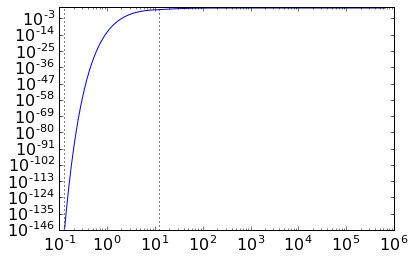

In [981]:
pl.figure()
pl.loglog(e_list,f_vec(e_list))
#pl.semilogx(e_list,np.vectorize(stepfun)(e_list))
#pl.axvline(psi_tr, linestyle=':', color='k')
#pl.ylim(1, 1e4)
#pl.xlim(0, 20.0)
#print psi(5)
pl.axvline(psi_min, color='k', linestyle=":")
pl.axvline(psi_tr, color='k', linestyle=":")
pl.show()

**Re-checking the density:**

In [1020]:
def vmax(x):
    return np.sqrt(2*float(psi(x)))

def dens(x):
    integ = lambda v: v**2*f(float(psi(x)) - 0.5*v**2)
    return 4*np.pi*quad(integ, 0, vmax(x))[0]

90.0341500070045


16.3615037817945
0.996296548210133


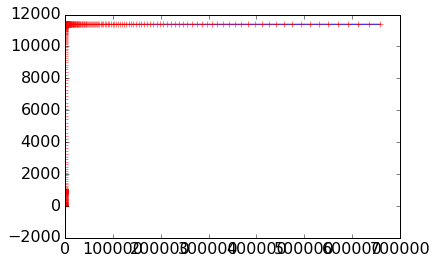

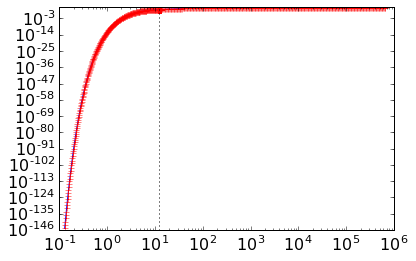

In [983]:
#print float(psi(2.0))
print psi(0.75)
print dens(0.75)/(rho0*rho(0.75))

pl.figure()
pl.plot(e_list,f_vec(e_list))
pl.plot(e_list,fvals,'r+')
#pl.semilogx(e_list,np.vectorize(stepfun)(e_list))
#pl.axvline(psi_tr, linestyle=':', color='k')
#pl.ylim(1e-10, 1000)
#pl.xlim(10, 30)
pl.show()

pl.figure()
pl.loglog(e_list,f_vec(e_list))
pl.loglog(e_list,fvals,'r+')
#pl.semilogx(e_list,np.vectorize(stepfun)(e_list))
pl.axvline(psi_tr, linestyle=':', color='k')
#pl.xlim(1, 16.36)
pl.show()

In [1021]:
xlist2 = np.logspace(np.log10(1e-4), np.log10(10),50)
#xlist2 = np.linspace(0.85, 1.15,10)
dens_list = 0.0*xlist2
for i in tqdm(range(len(xlist2))):
    dens_list[i] = dens(xlist2[i])

100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


7.29361455371641
226732.789361147


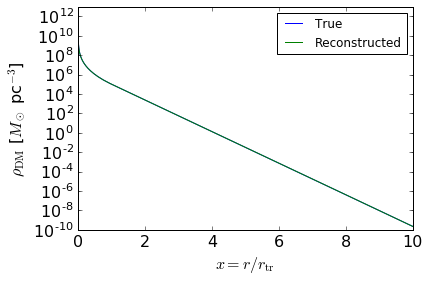

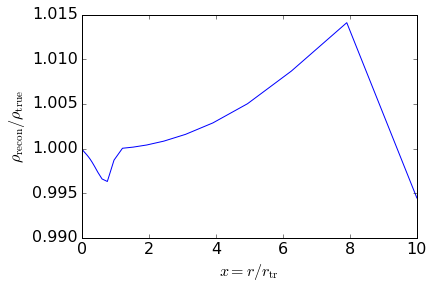

In [1024]:
print psi(1.7)
print rho0*rho(0.8)

pl.figure()
pl.semilogy(xlist2, rho0*np.vectorize(rho)(xlist2), label="True")
pl.semilogy(xlist2, dens_list, label="Reconstructed")
pl.legend(loc='best',fontsize=12.0)
pl.xlabel(r'$x = r/r_\mathrm{tr}$')
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")

pl.figure()
pl.plot(xlist2, (1/rho0)*dens_list/np.vectorize(rho)(xlist2))
pl.xlabel(r'$x = r/r_\mathrm{tr}$')
pl.ylabel(r"$\rho_\mathrm{recon}/\rho_\mathrm{true}$")
#pl.ylim(0.99,1.01)
#pl.xlim(0, 2)
pl.show()

In [1043]:
np.savetxt("distribution_trunc3.dat",zip(e_list,np.clip(fvals,0,1e30)))

In [1013]:
#Speed distribution f(v) at a given radius r
def f_scalar(x, v):
    if (v >= vmax(x)):
        return 0.0
    else:
        return 4.0*np.pi*(v**2)*f(float(psi(x)) - 0.5*v**2)/(rho0*rho(x))

f_v = np.vectorize(f_scalar)

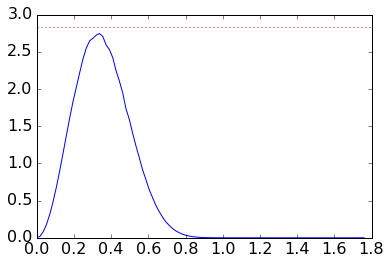

In [1039]:
xpos = 8.0
vlist = np.linspace(0, vmax(xpos),100)
#upper = 4*np.pi*vmax(xpos)**2*np.max(fvals[e_list < float(psi(xpos))])/rho(xpos)
#print upper
pl.figure()
pl.plot(vlist, f_v(xpos,vlist))
#pl.axhline(upper, linestyle=':', color='g')
pl.axhline(5.0/vmax(xpos), linestyle=':', color='r')
pl.show()
